# INTRODUCTION

This document takes a look at data from  https://botometer.iuni.iu.edu/bot-repository/datasets.html.  That data should already be present on your image, so no need to redownload data.

The goal is only to verify that data is present and to check what fields are available in the data.

Literature: https://arxiv.org/abs/1701.03017

There is data present from Twitter accounts in these catagories:

genuine_accounts.csv - Average user behavior 

social_spambots_1.csv - promoted mayor candidate in election

social_spambots_2.csv - spent several months promoting the #TALNTS hashtag

social_spambots_3.csv - advertised amazon.com products

Key research question:

How can algorithms distinguish a social spambot tweets from a genuine users tweets?  

How can algorithms do so without being vulnerable to adversarial manipulation? [possible answer: use the social graph]



In [2]:
# Fix import path
# Some configuration was missing in the AWS image. This fixes it.
import os
os.system("touch ~/botornot/src/__init__.py")
import sys
sys.path.insert(0, os.path.expanduser("~/botornot/src"))
sys.path.insert(0, os.path.expanduser("~/botornot/src/botornot_study"))

In [ ]:
sys.path

In [4]:
#Imports
from __future__ import print_function

import os
import sys
import numpy as np

from PIL    import Image
from pprint import pprint

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.dpi']= 200
matplotlib.rcParams["savefig.dpi"] = 200


import numpy as np
from glob import glob
import logging
import  tqdm
import pandas
from matplotlib import pyplot
import os
import botornot_study as bon
from botornot_study import import_data, logging_util
print(os.getcwd())
from importlib import reload
reload(import_data)


logging_util.basicConfig()

ModuleNotFoundError: No module named 'botornot_study'

## LOAD DATA

Loading the Cresci 2017 data from https://botometer.iuni.iu.edu/bot-repository/datasets.html
The data has been assembled and unzipped previously.

Notes about next code block:
- Some warnings about missing files is normal in the following block of code.  
- "cresci-2017.csv" is a directory.
- Takes a while to load.


In [ ]:
in_dir="data/datasets_full.csv"
print(glob(os.path.join(in_dir, "*")))
tweets_df, users_df = import_data.load_cresci_2017(in_dir)
print("...DONE")

# Examining Tweets


In [24]:
print("#### THERE ARE THE FOLLOWING FIELDS IN TWEET DATA ####")
print(tweets_df.keys())

print("#### THERE ARE THE FOLLOWING SOURCES OF TWEET DATA####")
print(np.unique(tweets_df.file_source))

print("#### WE ARE FOCUSING ON THESE TWO")
spambot = tweets_df[tweets_df.file_source == "social_spambots_2.csv"]
genuine = tweets_df[tweets_df.file_source == "genuine_accounts.csv"]
spambot_3 = tweets_df[tweets_df.file_source == "social_spambots_3.csv"]





#### THERE ARE THE FOLLOWING FIELDS IN TWEET DATA ####
Index(['contributors', 'crawled_at', 'created_at', 'favorite_count',
       'favorited', 'file_source', 'geo', 'id', 'in_reply_to_screen_name',
       'in_reply_to_status_id', 'in_reply_to_user_id', 'num_hashtags',
       'num_mentions', 'num_urls', 'place', 'possibly_sensitive',
       'reply_count', 'retweet_count', 'retweeted', 'retweeted_status_id',
       'source', 'text', 'timestamp', 'truncated', 'updated', 'user_id'],
      dtype='object')
#### THERE ARE THE FOLLOWING SOURCES OF TWEET DATA####
['fake_followers.csv' 'genuine_accounts.csv' 'social_spambots_1.csv'
 'social_spambots_2.csv' 'social_spambots_3.csv'
 'traditional_spambots_1.csv']
#### WE ARE FOCUSING ON THESE TWO
#### COUNTS ####
genuine has 2839362 records
  contributors           crawled_at                      created_at  \
0          NaN  2015-05-01 12:57:19  Fri May 01 00:18:11 +0000 2015   
1          NaN  2015-05-01 12:57:19  Thu Apr 30 21:50:52 +0000 2015 

In [36]:
# WHAT'S IN THESE DATA FRAMES
np.random.seed(43)
rand = np.random.choice(range(len(genuine)), 10, replace=False)
print("\n#### 10 Examples of Genuine Account Tweets####\nTWEET:")
print(*genuine.text.iloc[rand], sep="\nTWEET:\n")


# WHAT'S IN THESE DATA FRAMES
rand = np.random.choice(range(len(spambot)), 10, replace=False)
print("\n#### 10 Examples of Spambot Account Tweets####\nTWEET:")
print(*spambot.text.iloc[rand], sep="\nTWEET:\n")






#### 10 Examples of Genuine Account Tweets####TWEET:
@JimDalrympleII Thousands of acres of California farmland are reverting to desert as zero water allocation goes into second year.
TWEET:
@agoldfisher @avemii @diodesign Ctrl C(n)V
TWEET:
A Picture says a thousand words ! http://t.co/I0fTUuGqoV
TWEET:
IDFWU!!! $$$
TWEET:
Now it's time for another @ThisJordanKing first! (at @Whataburger) http://t.co/fCvk6VlMfL
TWEET:
RT @ArabOrionJYJ: (HQ Pics) 140929 يوتشون و جيجونغ من حدث توقيع جي واي جي للمعجبين  ♥  ♥ http://t.co/3rTgqdJK6Y
TWEET:
RT @JessieJessup: What if "goats who scream like people" really ARE people paying a karmic debt in goat form who are aware &amp; trying  ...
TWEET:
@BPayton216 She's just got a lot of love to give 
TWEET:
@annabellegrifff ⚠️ATTENTION HOT HUMAN BEANZ⚠️ will see movie if you will cuddle
TWEET:
RT @matbeal: Is anyone not Taylor Swift's best mate? #britawards

#### 10 Examples of Spambot Account Tweets####TWEET:
@TomFitchArt "If you have the courage to begin,

In [ ]:
## CREATING DATA FOR BOXPLOTS

In [53]:
tweets_2 = tweets_df
tweets_2.columns

from matplotlib import pyplot as plt
import seaborn as sns
import collections
from tqdm import tqdm

numeric_fields = ["favorite_count", "num_hashtags", "num_mentions", "num_urls", "possibly_sensitive", "reply_count",
                  "retweet_count", "retweeted" ]


### CALCULATING BY USER STATS
ret_list = []

for k, v in tqdm(tweets_2.groupby("user_id")):
    ntweets = len(v)
    if ntweets < 3: 
        continue
    # means
    ret = collections.OrderedDict()
    ret["user_id"] = k
    ret["ntweets"] = len(v)
    ret["file_source"] = v.file_source.values[0]
    tweet_text = v.text.values
    # Some summaries of numeric fields on tweet data
    for c in numeric_fields:
        values = np.array(v[c], dtype=np.float)
        values[np.isnan(values)] = 0.0
        ret["mean_%s" % c] = np.mean(values)
        ret["rate_%s" % c] = np.mean(values > 0)
        #ret["std_%s" % c] = np.std(values)
        #ret["coef_var_%s" % c] = np.std(values)/(np.mean(values) + 0.001)
    
    # Some summary of inter-arrival time of crawled tweets
        
    ret_list.append(ret)

user_tweet_summary_df = pandas.DataFrame.from_records(ret_list, columns=ret_list[0].keys())


user_by_file = {k:v for k,v in user_tweet_summary_df.groupby("file_source")}

user_sum_melted = user_tweet_summary_df.melt(id_vars=["file_source", "user_id"])

os.makedirs("fig", exist_ok=1)
for c in tqdm(user_tweet_summary_df.columns):
    if c in  ["user_id", "file_source"]:
        continue
    plt.clf()
    plt.figure(figsize=(6, 4))
    ax =  sns.boxplot(x="file_source", y = c, data=user_tweet_summary_df)
    plt.xticks(rotation=90)
    plt.savefig("fig/source_boxplot_%s.png" % c, bbox_inches='tight')
    plt.close()

print("...DONE")

100%|██████████| 19/19 [00:06<00:00,  2.57it/s]

...DONE


<Figure size 1200x800 with 0 Axes>

#### LOADING IMAGES SAVED TO DISK ####
LOADING fig/source_boxplot_rate_reply_count.png


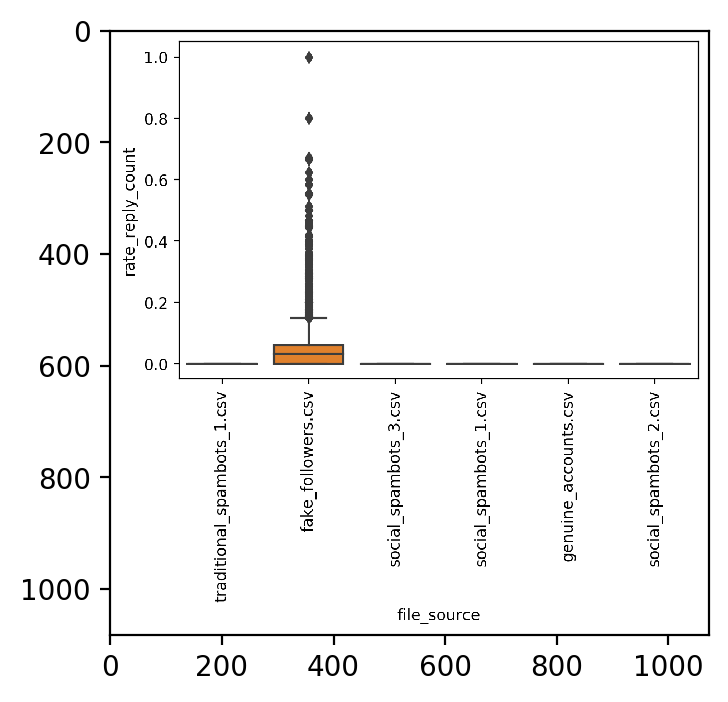

LOADING fig/source_boxplot_rate_favorite_count.png


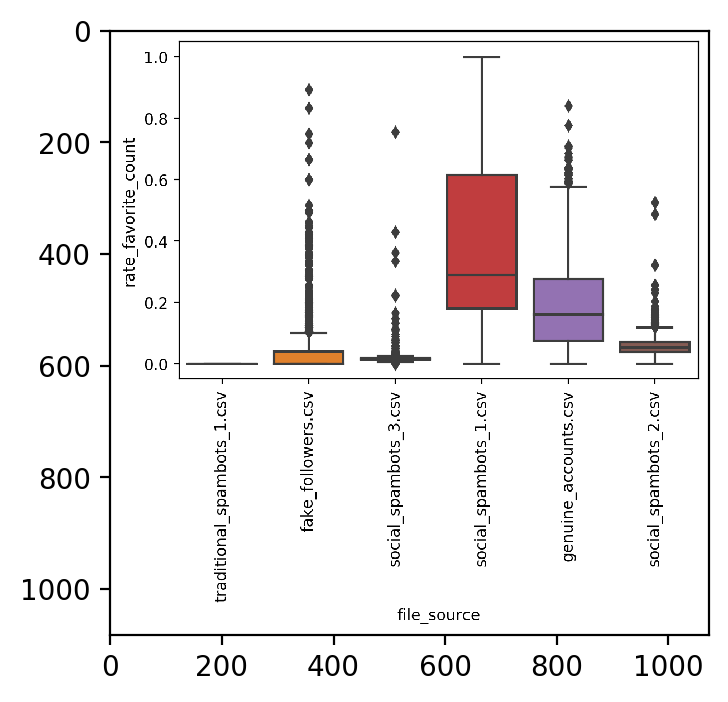

LOADING fig/source_boxplot_rate_num_mentions.png


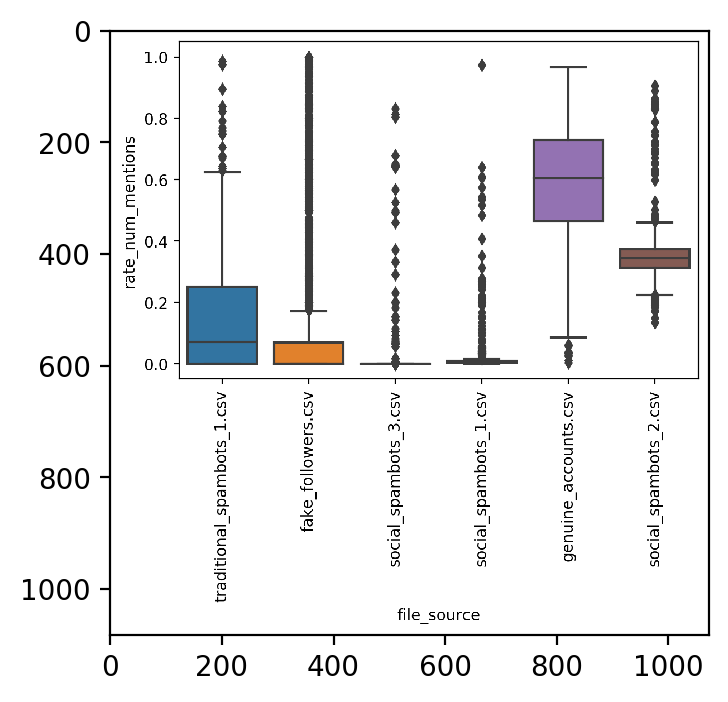

LOADING fig/source_boxplot_rate_retweeted.png


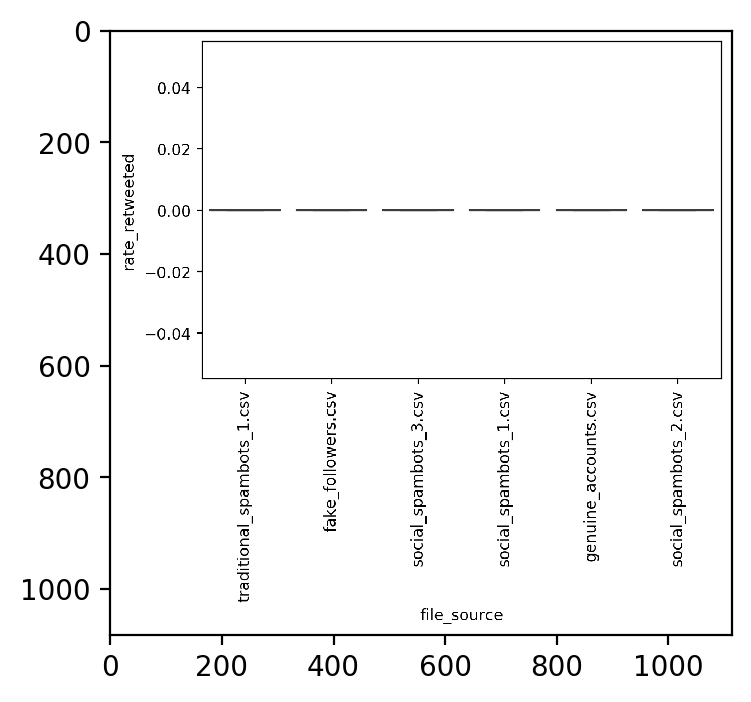

LOADING fig/source_boxplot_rate_possibly_sensitive.png


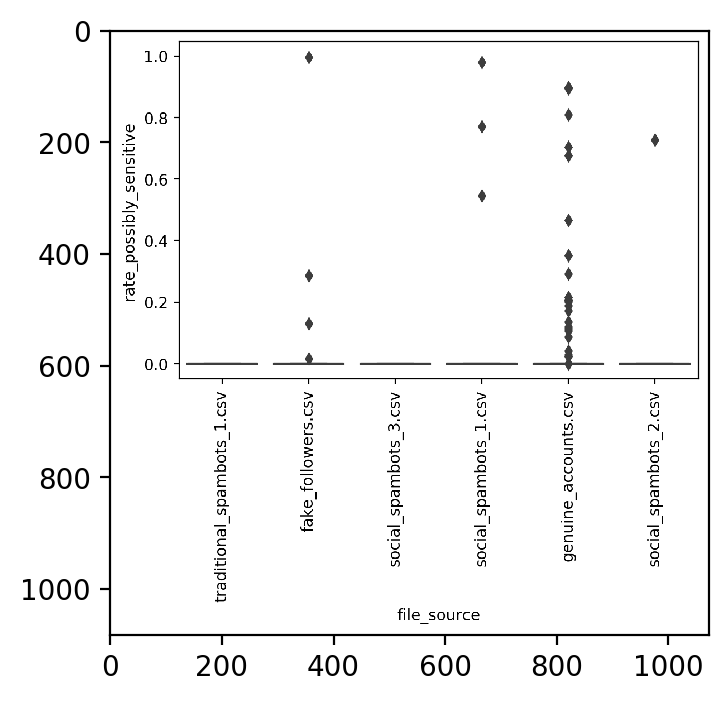

LOADING fig/source_boxplot_mean_possibly_sensitive.png


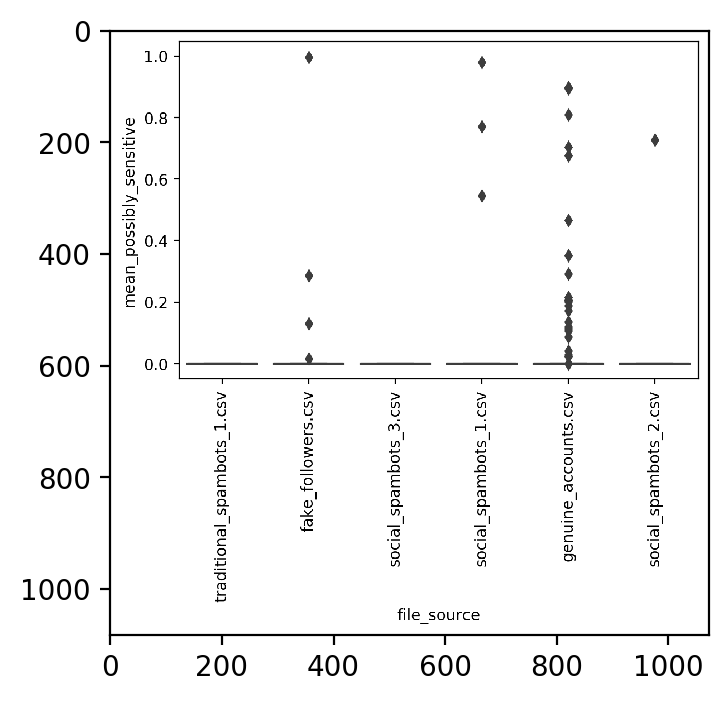

LOADING fig/source_boxplot_mean_retweeted.png


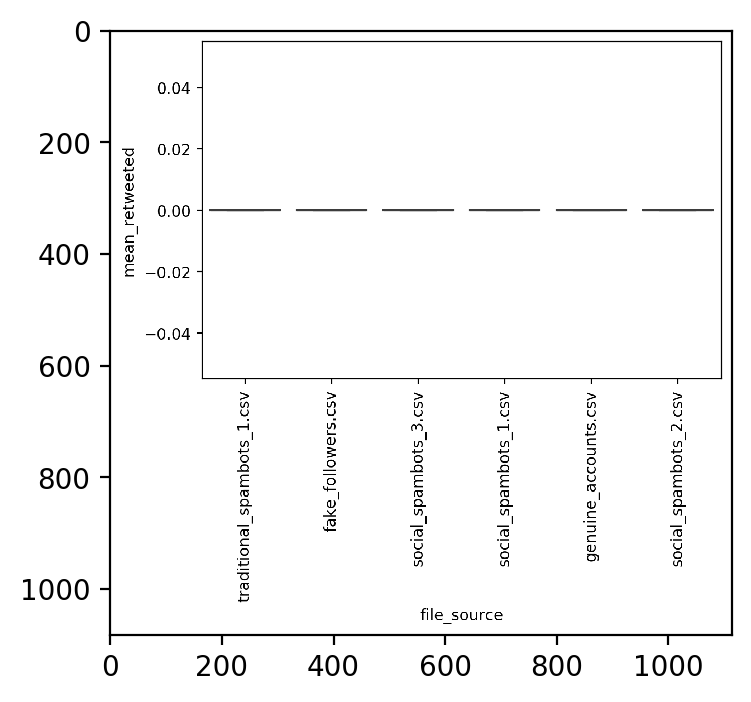

LOADING fig/source_boxplot_mean_retweet_count.png


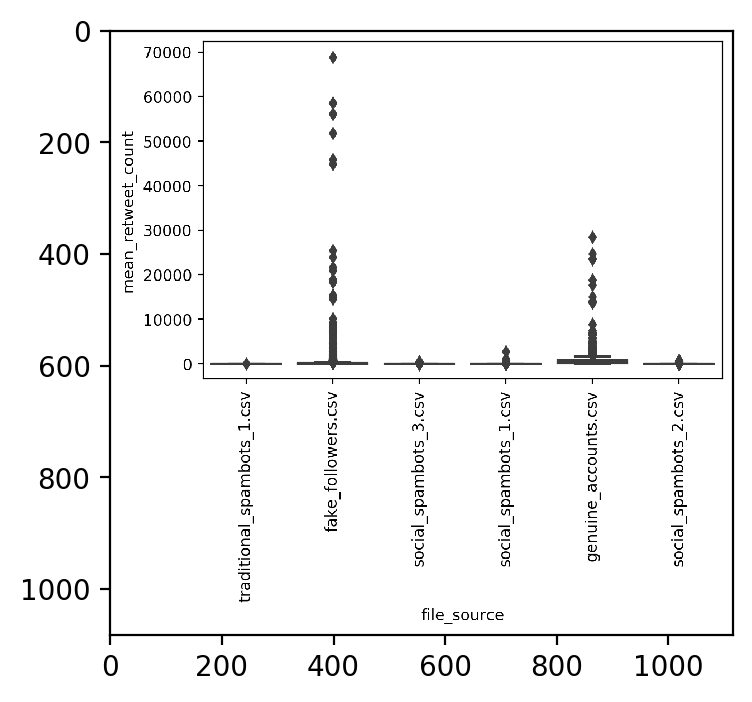

LOADING fig/source_boxplot_mean_num_urls.png


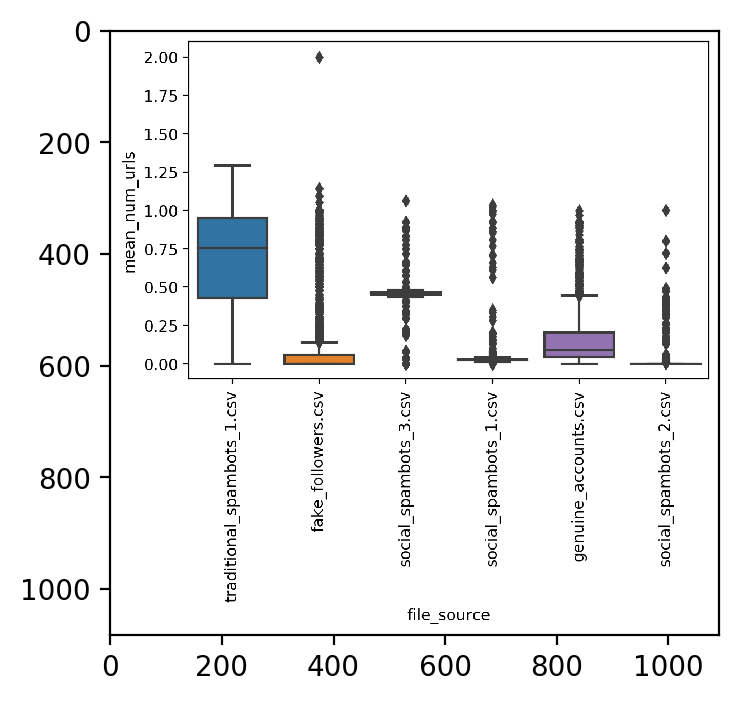

LOADING fig/source_boxplot_rate_num_hashtags.png


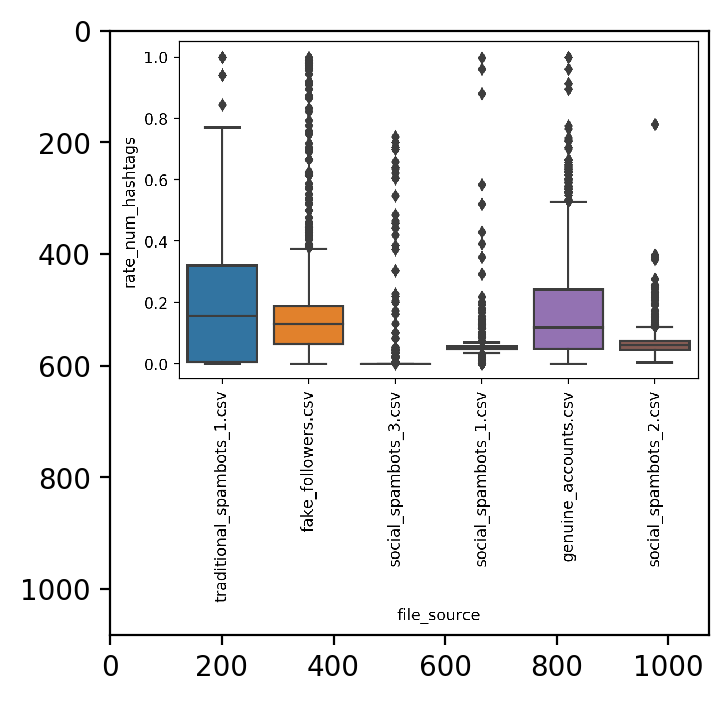

LOADING fig/source_boxplot_mean_num_hashtags.png


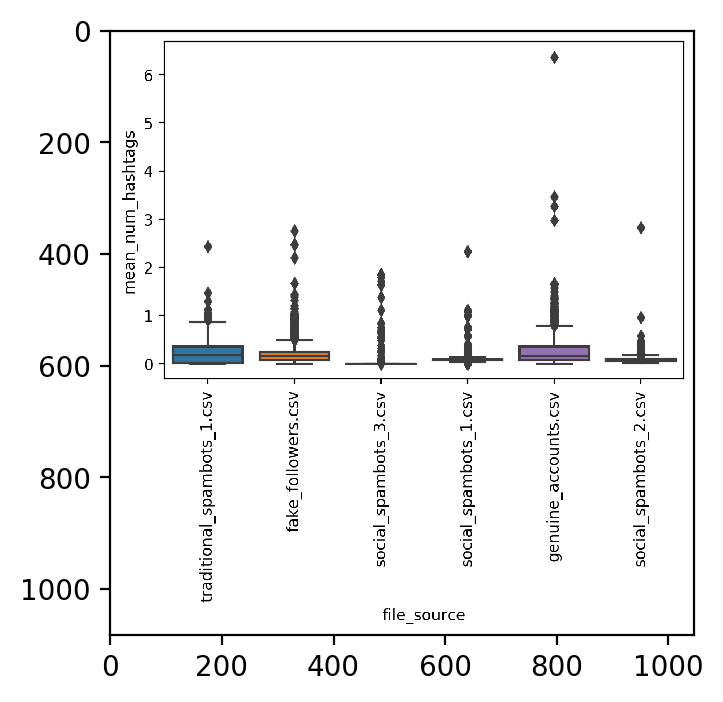

LOADING fig/source_boxplot_mean_reply_count.png


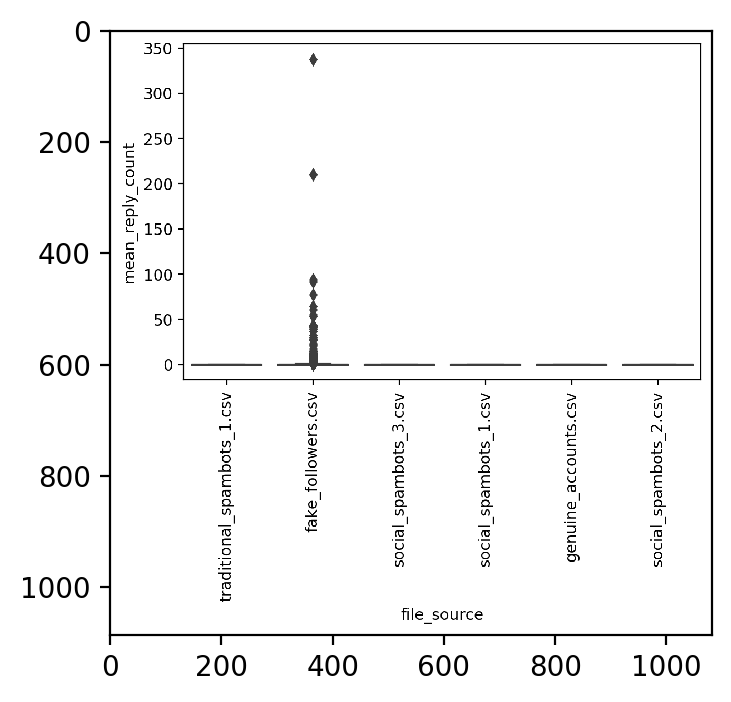

LOADING fig/source_boxplot_rate_retweet_count.png


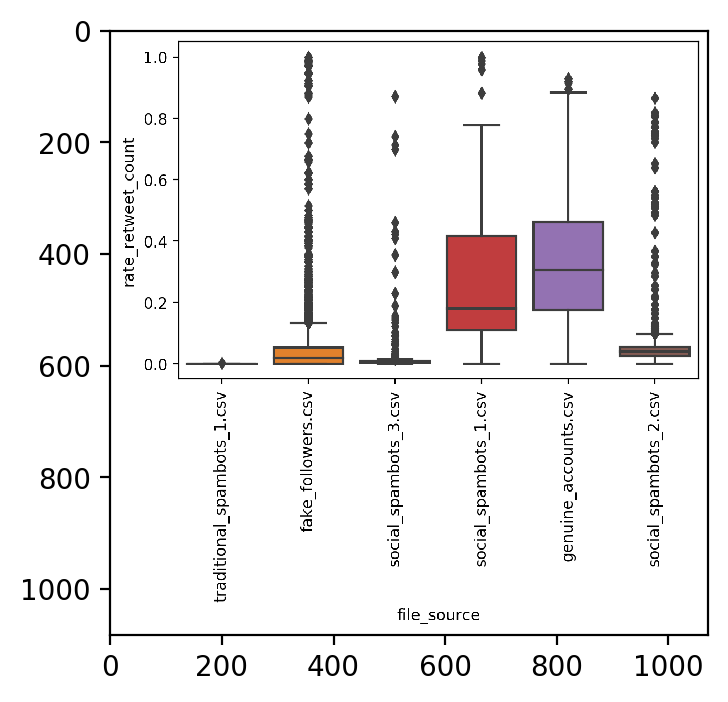

LOADING fig/source_boxplot_mean_num_mentions.png


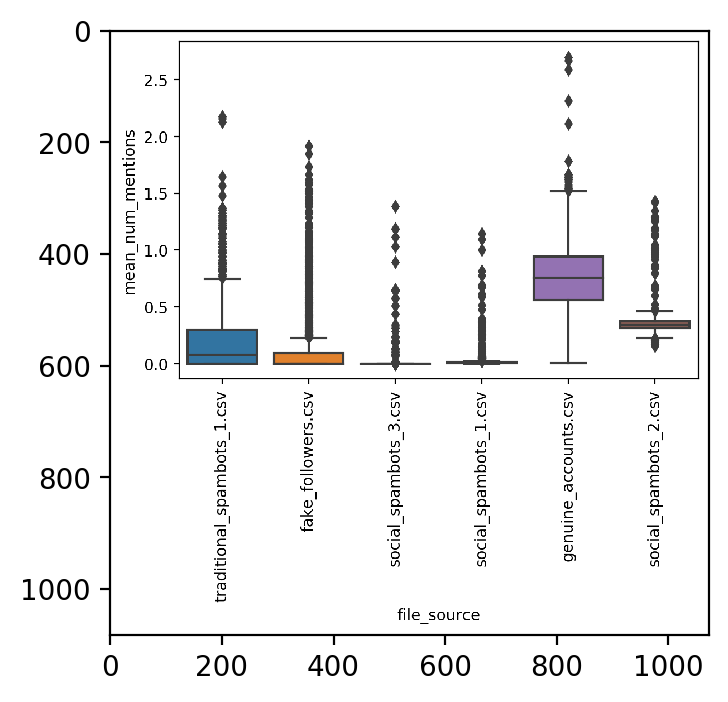

LOADING fig/source_boxplot_ntweets.png


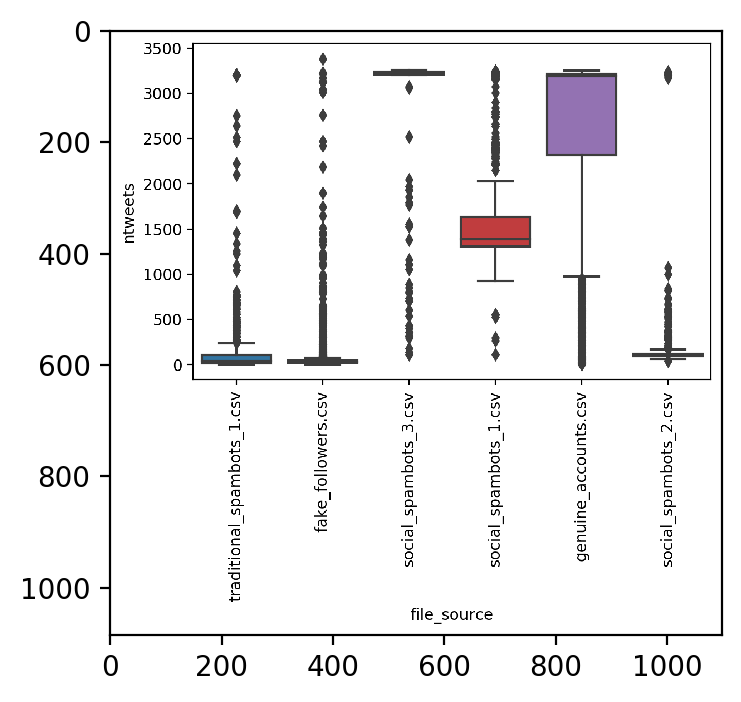

LOADING fig/source_boxplot_rate_num_urls.png


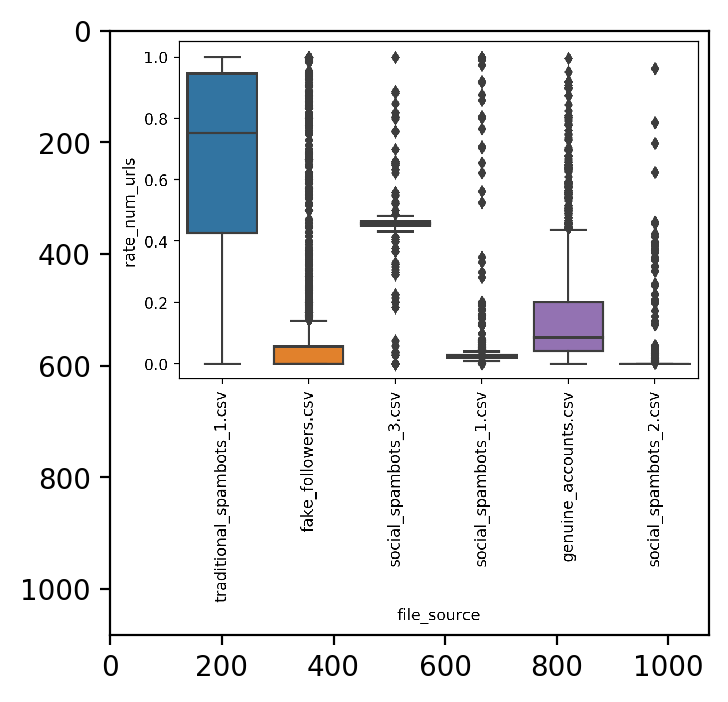

LOADING fig/source_boxplot_mean_favorite_count.png


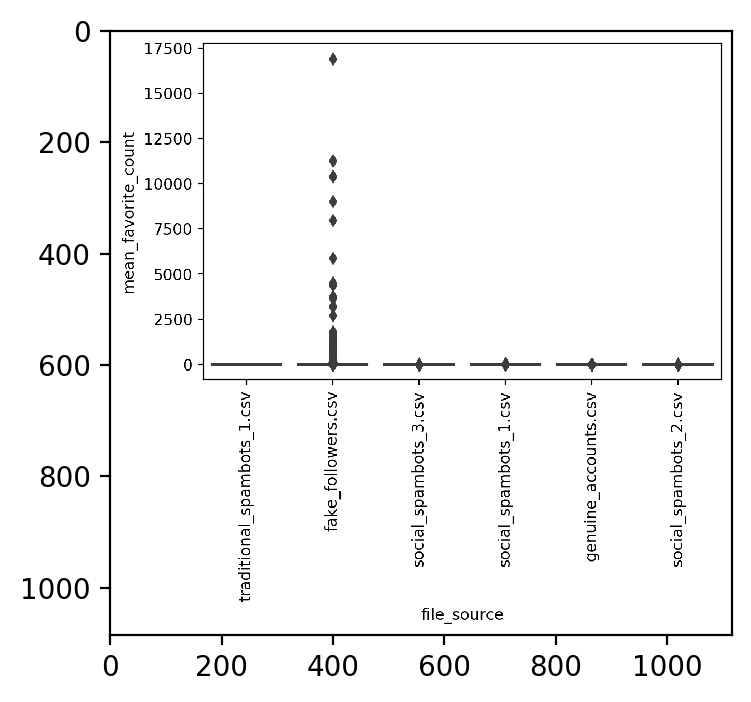

In [54]:
print("#### LOADING IMAGES SAVED TO DISK ####")
image_files = glob("fig/*png")
for file in image_files:
    print("LOADING %s" % file)
    image = Image.open(file)
    plt.figure()
    plt.imshow(image)
    plt.show()